# Code for Cplex formulation of Alstom problem

In [685]:
import math
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb

## Approximating the functions with polynomials

### RAV function

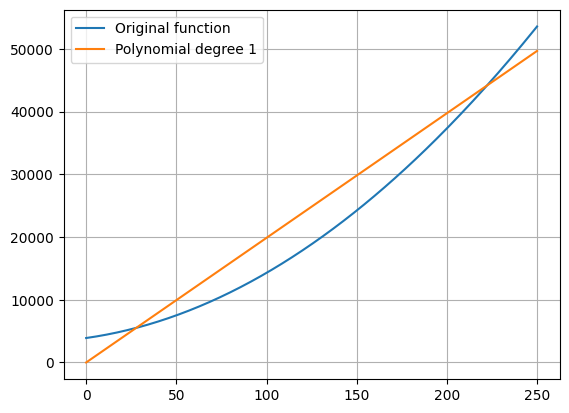

In [686]:
A, B, C, m, v_max, p_max, c_max = 3900, 40.7, 0.632, 400000, 220, 4305220, 320000
import numpy as np


def P(v):
    return (A + B * v + C * v**2)


a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 220)
y_points_bis = []
for x in x_points:
    y_points_bis.append(P(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)
coeffs[1] = 0
# Create polynomial function
Prav_poly = np.poly1d(coeffs)


def Prav(v):
    return Prav_poly(v)
# Remove RAV to simplify the problem
'''def Prav(v):
    return 0'''

y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Prav(x_points[i]))


if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Traction

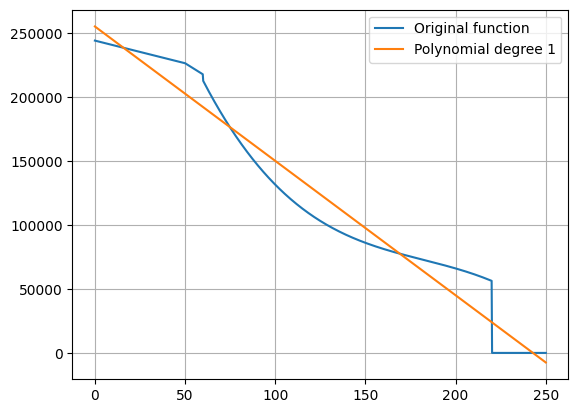

In [687]:
def f(v):
    if 0 <= v <= 50:
        return -354.1 * v + 2.44 * (10**5)
    elif 50 <= v < 60:
        return -881.3 * v + 2.704 * (10**5)
    elif 60 <= v < 220:
        return -0.05265 * (v**3) + 28.78 * (v**2) - 5603 * v + 4.566 * (10**5)
    else:
        return 0
    
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)

# Create polynomial function
Ptraction = np.poly1d(coeffs)


y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Ptraction(x_points[i]))

F_pos_max = max(y_points_approx)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Braking

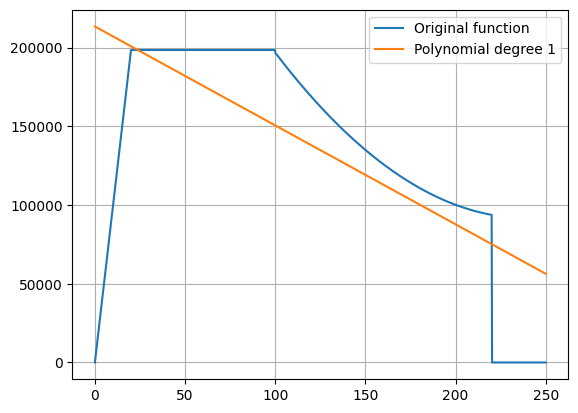

In [688]:
def f(v):
    if 0 <= v <= 20:
        return 9925 * v + 1.243
    if 20 <= v <= 100:
        return 2.039 * (10**-13) * v + 1.985 * (10**5)
    if 100 <= v <= 220:
        return 5.389 * (v**2) - 2583 * v + 4.012 * (10**5)
    else:
        return 0


# Interval [a, b] and degree n
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)

# Create polynomial function
Pbraking = np.poly1d(coeffs)



y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Pbraking(x_points[i]))

F_neg_max = max(y_points_approx)
F_max = max(F_pos_max, F_neg_max)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Power usage

[-1.91022402e-16  7.13384433e-01  0.00000000e+00  2.46745051e-02]
The polynomial is: -1.9102240217704484e-16 + 0.7133844326799073*x + 0.0*y + 0.024674505091040418*x*y


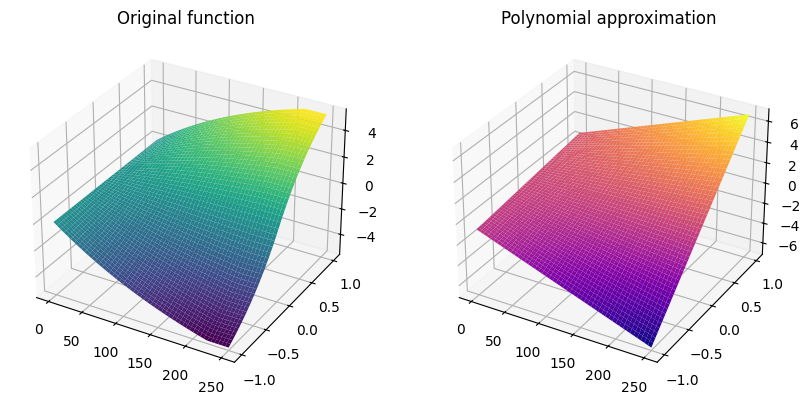

In [689]:
def cost(V, demand):
    F_max = 1
    V_max = 220
    F = demand
    p_max = 4305220
    c_max = 320000
    V_safe = min(V, V_max)
    # Ensure V is within a safe range for math.exp
    c = (
        (1 - math.exp(-V_safe / (V_max + 0.001)))
        * math.tanh(100 * F)
        * (1 - math.exp(-abs(F) / (F_max + 0.001)))
    )
    Puti = (c / c_max) * p_max
    # For now we ignore regen braking
    '''if Puti < 0:
        Puti = 0
    elif Puti > p_max:
        Puti = p_max'''
    return Puti


# Define the domain
a_x, b_x = 0, 250
a_y, b_y = -1, 1
n = 1  # degree in x
l = 1  # degree in y

# Create the interpolation points (equally spaced)
x_points = np.linspace(a_x, b_x, 1000)
y_points = np.linspace(a_y, b_y, 1000)
X, Y = np.meshgrid(x_points, y_points, indexing="ij")
Z = np.eye(1000)
for i in range(len(x_points)):
    for j in range(len(y_points)):
        x = x_points[i]
        y = y_points[j]
        Z[i, j] = cost(x, y)


# Build the Vandermonde matrix for 2D
x_flat = X.ravel()
y_flat = Y.ravel()

A = np.vstack([(x_flat**i) * (y_flat**j) for i in range(n + 1) for j in range(l + 1)]).T

b = Z.ravel()
coeffs_pow, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
print(coeffs_pow)
print(f"The polynomial is: {coeffs_pow[0]} + {coeffs_pow[1]}*x + {coeffs_pow[2]}*y + {coeffs_pow[3]}*x*y")


# Define the polynomial function
def Ppower(x, y):
    val = 0
    idx = 0
    for i in range(n + 1):
        for j in range(l + 1):
            val += coeffs_pow[idx] * (x**i) * (y**j)
            idx += 1
    return val


# Evaluation grid
x_eval = x_points
y_eval = y_points
X_eval, Y_eval = np.meshgrid(x_eval, y_eval, indexing="ij")
Z_eval = Ppower(X_eval, Y_eval)

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X_eval, Y_eval, Z, cmap="viridis")
ax.set_title("Original function")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X_eval, Y_eval, Z_eval, cmap="plasma")
ax2.set_title("Polynomial approximation")

plt.show()

Text(0.5, 1.0, 'Max acceleration at constant power vs Speed')

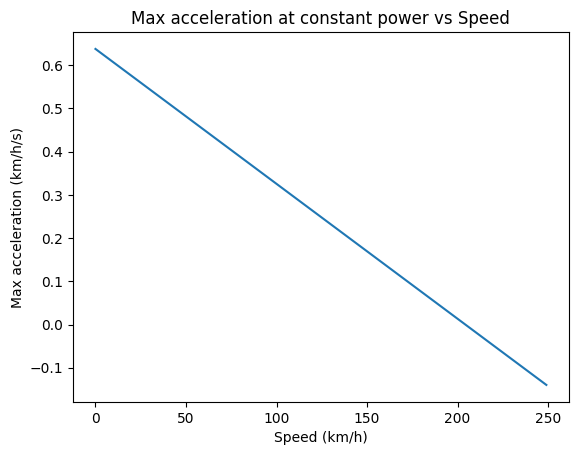

In [690]:
# Testing speed at constant maximum power
v = np.arange(0, 250, 1)
max_acceration = []
for speed in v:
    acc = (Ptraction(speed)-Prav_poly(speed)) / m
    max_acceration.append(acc)


plt.plot(v, max_acceration, label="Max acceleration at constant power")
plt.xlabel("Speed (km/h)")
plt.ylabel("Max acceleration (km/h/s)")
plt.title("Max acceleration at constant power vs Speed")

## Defining the Model

### Define model

In [691]:
opt_model = Model(name="Poly_Model")
N = 10
Dist = 0.001
dt = 10

### Define variables

In [692]:
v={}
for i in range(0, N):
    v[i]= opt_model.continuous_var(name=f"v_{i}",lb=0, ub=v_max)

d={}
for i in range(0, N):
    d[i]= opt_model.continuous_var(name=f"d_{i}",lb=0, ub=2)

### Cost function

#### Linearization

In [693]:
'''# Here we linearize the D*v part of the polynomial approximation of our cost function

w1 = {}
for i in range(0, N):
    w1[i] = opt_model.continuous_var(name=f"w1_{i}",lb=0,ub=v_max)

V_min, V_max = 0, 250
d_min, d_max = -1, 1

# coefficients from polynomial fit of cost function (Power consumption)
c0, c1, c2, c3 = coeffs_pow

for i in range(0, N):
    opt_model.add_constraint(w1[i] >= d_min*v[i] + (d[i]-1)* V_min - V_min * d_min)
    opt_model.add_constraint(w1[i] >= d_max*v[i] + (d[i]-1)* V_max - V_max * d_max)
    opt_model.add_constraint(w1[i] <= d_max*v[i] + (d[i]-1)* V_min - d_max * V_min)
    opt_model.add_constraint(w1[i] <= d_min*v[i] + (d[i]-1)* V_max - d_min * V_max)'''

'# Here we linearize the D*v part of the polynomial approximation of our cost function\n\nw1 = {}\nfor i in range(0, N):\n    w1[i] = opt_model.continuous_var(name=f"w1_{i}",lb=0,ub=v_max)\n\nV_min, V_max = 0, 250\nd_min, d_max = -1, 1\n\n# coefficients from polynomial fit of cost function (Power consumption)\nc0, c1, c2, c3 = coeffs_pow\n\nfor i in range(0, N):\n    opt_model.add_constraint(w1[i] >= d_min*v[i] + (d[i]-1)* V_min - V_min * d_min)\n    opt_model.add_constraint(w1[i] >= d_max*v[i] + (d[i]-1)* V_max - V_max * d_max)\n    opt_model.add_constraint(w1[i] <= d_max*v[i] + (d[i]-1)* V_min - d_max * V_min)\n    opt_model.add_constraint(w1[i] <= d_min*v[i] + (d[i]-1)* V_max - d_min * V_max)'

#### Definition

In [694]:
# Total cost
total_cost = opt_model.sum(d[i] for i in range(0, N))
opt_model.maximize(total_cost)

### Speed physics constraints (there is a problem somewhere in here)

#### Linearising

In [695]:
# Here we define the delta variables which are binary variables indicating whether we are acceleration or braking (ie. d>1 or d<1)
delta={}
for i in range(0, N):
    delta[i]= opt_model.binary_var(name=f"delta_{i}")

Big_M = 2
epsilon = 1e-6


for i in range(0, N):
    opt_model.add_constraint((d[i]-1) >= epsilon - Big_M * (1 - delta[i]))
    opt_model.add_constraint((d[i]-1) <= Big_M * delta[i])

    


In [696]:
# Here we define and linearize z1=delta*F_traction and z2=(1-delta)*F_braking
z1={}
z2={}
for i in range(0, N):
    z1[i]= opt_model.continuous_var(name=f"z1_{i}",lb=0,ub=F_max)
    z2[i]= opt_model.continuous_var(name=f"z2_{i}",lb=0,ub=F_max)

L1 = 0
L2 = 0
U1 = F_max
U2 = F_max


for i in range(0, N):
    opt_model.add_constraint(z1[i] <= delta[i]*U1)
    opt_model.add_constraint(z2[i] <= (1 - delta[i]) * U2)

    opt_model.add_constraint(z1[i] <= Ptraction(v[i]))
    opt_model.add_constraint(z2[i] <= Pbraking(v[i]))

    opt_model.add_constraint(z1[i] <= Ptraction(v[i]) -(1 - delta[i])*U1)
    opt_model.add_constraint(z2[i] <= Pbraking(v[i]) - (1 - (1 - delta[i])) * U2)
    
    opt_model.add_constraint(z1[i] >= 0)
    opt_model.add_constraint(z2[i] >= 0)


In [697]:
# Here we linearize w2 = (D)*(z1 + z2)

w2 = {}
for i in range(0, N):
    w2[i] = opt_model.continuous_var(name=f"w2_{i}",lb=0,ub=F_max)

dL, dU = 0, 2
zL, zU = 0, F_max

for i in range(0, N):
    opt_model.add_constraint(w2[i] >= dL * (z1[i] + z2[i]) + (d[i]) * zL - zL * dL)
    opt_model.add_constraint(w2[i] >= dU * (z1[i] + z2[i]) + (d[i]) * zU - zU * dU)
    opt_model.add_constraint(w2[i] <= dU * (z1[i] + z2[i]) + (d[i]) * zL - dU * zL)
    opt_model.add_constraint(w2[i] <= dL * (z1[i] + z2[i]) + (d[i]) * zU - dL * zU)



#### Definition

In [698]:
# Here we define the final speed constraint on, where the acceleration is the difference between the effort applied and the resistive forces divided by the mass
for i in range(1,N-2):
    opt_model.add_constraint(
    v[i+1] == v[i] + (dt/m) * (w2[i]-(z1[i] + z2[i])-Prav(v[i])),
    f"Velocity constraint {i}"
)

In [699]:
# Additional constraints for speed
opt_model.add_constraint(v[0] == 0, "Initial velocity")
'''opt_model.add_constraint(v[N-1] == 0, "Final velocity")'''

# Just to make sure
for i in range(0, N):
    opt_model.add_constraint(v[i]>= 0, f"Velocity non-negativity {i}")

## Distance constraints

In [700]:
# Add a distance constraint to ensure the train will start moving
'''Distance = 0
for i in range(0, N):
    Distance += v[i]*dt/3600

opt_model.add_constraint(Distance >= Dist, "Total distance constraint")'''

'Distance = 0\nfor i in range(0, N):\n    Distance += v[i]*dt/3600\n\nopt_model.add_constraint(Distance >= Dist, "Total distance constraint")'

## Problem Verification

In [701]:
# Print info on the model
opt_model.print_information()

Model: Poly_Model
 - number of variables: 60
   - binary=10, integer=0, continuous=50
 - number of constraints: 158
   - linear=158
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


## Solving

In [702]:
# Here we solve the model

# Some parameters to set for the solver
'''opt_model.parameters.timelimit = 60  # Set a time limit (seconds)
opt_model.parameters.mip.tolerances.mipgap = 1e-6  # Acceptable optimality gap
opt_model.parameters.mip.tolerances.integrality = 1e-12  # Integrality tolerance
'''

result = opt_model.solve(log_output=True)
if result:
    v_sol = [result.get_value(v[i]) for i in range(N)]
    d_sol = [result.get_value(d[i])-1 for i in range(N)]
    delta_sol = [result.get_value(delta[i]) for i in range(N)]
    print("Solution found")
else:
    print("No solution found.")

Dists = []
for i in range(0, N):
    Dists.append(sum(v_sol[:i]))

Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 151 rows and 53 columns.
Aggregator did 7 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.12 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.12 ticks)
Parallel b&c, 20 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.12 ticks)
Solution found


## Visualization

**The problem comes in the way the speed/demand/delta interaction constraints are not respected**

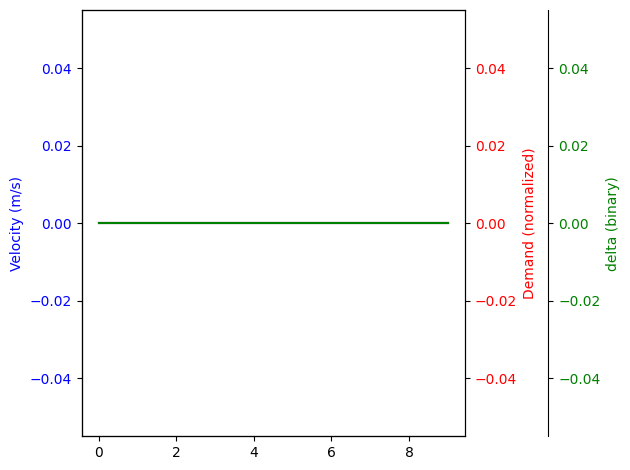

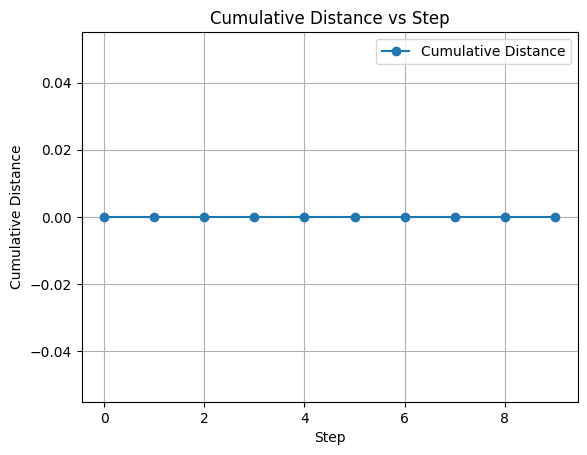

In [703]:
fig, ax1 = plt.subplots()

ax1.plot(v_sol, 'b-', label='Velocity (m/s)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(d_sol, 'r-', label='Demand (normalized)')
ax2.set_ylabel('Demand (normalized)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(delta_sol, 'g-', label='delta (binary)')
ax3.set_ylabel('delta (binary)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

# Plot Dists vs index
plt.figure()
plt.plot(Dists, marker='o', label='Cumulative Distance')
plt.xlabel('Step')
plt.ylabel('Cumulative Distance')
plt.title('Cumulative Distance vs Step')
plt.grid(True)
plt.legend()
plt.show()

In [704]:
print(v_sol)
print(d_sol)
print(delta_sol)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
